# Introduction to text analytics seminar.

Author: Dr Stef Garasto.

Licence: [GPLv3](https://choosealicense.com/licenses/gpl-3.0/).


Python script to reproduce (approximately and partially) the paper ["Analyzing Gender Bias within Narrative Tropes"](https://aclanthology.org/2020.nlpcss-1.23.pdf) by Gala et al.

The goal is to show some useful text analytics techniques in context.

Specifically, we will see:

- some cleaning steps and a bit about regular expressions.
- extract and plot top terms in a collection of documents (using a count-based Bag of Words model).
- match specific keywords in a text.
- a bit about **approximate** matching of specific keywords in a text (using word embeddings).
- topic modelling using Latent Dirichlet Allocation.

These techniques are applied to try and quantify the **binary** "genderedness" of tropes and topics within those tropes.


In [1]:
#import spacy
import numpy as np
import pandas as pd
import time
import requests
import os
import re
import cleantext
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import spacy


In [2]:
#!python -m spacy download en_core_web_sm #,en_core_web_md

## Data loading

In [3]:
data_folder = 'TVTropesData'

In [4]:
# load tropes and example occurrences in films
tropes = pd.read_csv(os.path.join(data_folder, 'tropes_v3.csv'))
film_tropes = pd.read_csv(os.path.join(data_folder, 'film_tropes_v3.csv'))
film_to_genre = pd.read_csv(os.path.join(data_folder, 'film_to_genres.csv'))


In [5]:
tropes.head()

,TropeID,Trope,Description
0,t00001,AbandonedArea,\nAbandoned places make good settings for fict...
1,t00002,AbandonedCatchphrase,Catchphrases are a great and simple way to hel...
2,t00003,AbandonedHospital,The creepy abandoned hospital/mental instituti...
3,t00004,AbandonedHospitalAwakening,"An Abandoned Hospital Awakening is, as the nam..."
4,t00005,AbandonedInfoPage,When a work is getting more and more complicat...


In [6]:
# how many tropes do we have?
len(tropes)

22554

In [7]:
tropes.sample(5, random_state=2)

,TropeID,Trope,Description
6727,t09148,GladIThoughtOfIt,Bob and Alice have a problem. Bob has a brilli...
20314,t27637,KillThemAll,"\nWhen Anyone Can Die becomes ""Everyone Will D..."
3927,t05339,DecemberDecemberRomance,\nRomantic love that arises between two elderl...
9044,t12335,KillEnemiesToOpen,"A trope often seen in Video Games, these doors..."
9742,t13255,LoveCanMakeYouGonk,Warning signs of a character about become Gonk...


In [72]:
film_tropes.sample(5, random_state=45)

,Title,Trope,Example,trope_id,title_id,TropeLower,ReadableTrope,AllExamples
162372,ItsAWonderfulLife,BeautifulCondemnedBuilding,wonderful life mary love old granville house p...,t02001,f6267,beautifulcondemnedbuilding,Beautiful Condemned Building,accepted old mental hospital would become sout...
96561,Dune,InnerMonologue,inner monologue david lynchs adaptation dune i...,t11478,f3716,innermonologue,Inner Monologue,variation child actor peter billingsly spends ...
402179,ThisFilmIsNotYetRated,OmniscientCouncilOfVagueness,documentary film yet rated argues motion pictu...,t28072,f15468,omniscientcouncilofvagueness,Omniscient Council Of Vagueness,marvel cinematic universe avengers world secur...
412744,TransformersAgeOfExtinction,OneToMillionToOne,transformers age extinction ksis line massprod...,t16169,f15786,onetomilliontoone,One To Million To One,bram stokers dracula among transformations dra...
30015,BadDreams1988,DeadAllAlong,harris cult perish fire burnt harris seen cynt...,t05182,f1093,deadallalong,Dead All Along,james mason picture place ones annette possess...


## Some data cleaning

In [9]:

# example problem - small spelling inconsistencies (compare "Back" and "back") where the trope is actually the same
print(tropes[['Trope','Description']].iloc[[5992,20022]].values)


[['Flashback'
  "A narrative technique in which we're shown events that took place before the episode's main action. Said events may have taken place on-screen earlier, but may also be new scenes depicting things hitherto only referenced.\nSpecific types of flashbacks include:\nSub-Trope of Separate Scene Storytelling. Dreaming of Times Gone By and Bad Dreams are two ways to show them. See also Flashback Effects for ways of distinguishing a Flash Back from normal action, and Viewers Are Goldfish for flashbacks to events that are still fresh in the audience's mind. It's also a brilliant way to indulge in some Exposition of Immortality. The inverse of this trope is the Flashforward, which depicts events in the future instead of the past.\nWhen a character is having a flashback, it can be because of psychic/magical powers, Post Traumatic Stress Disorder or simply resurfacing memories. In either case, it's a common justification for a movie to show the audience a Flashback.\nIf you want th

In [10]:
# other problem - presence of null values
film_tropes[film_tropes.Example.isna()].head(2)


,Title,Trope,Example,trope_id,title_id
105,ABeautifulMind,AllThereIsToKnowAboutTheCryingGame,NaN,t00635,f3
202,ABridgeTooFar,RealityIsUnrealistic,NaN,t18301,f13


In [11]:
# drop all the NaN values where it matters
film_tropes = film_tropes.dropna(subset= ['Trope','Example'])
tropes = tropes.dropna(subset= ['Trope','Description'])


In [12]:
# make a copy of the Trope name and change to lowercase
film_tropes['TropeLower'] = film_tropes['Trope'].str.lower()

# now we can drop duplicates rows, those that contain the same example for the same trope
# note that if we wanted to be precise, 
# we'd drop the same example for the same trope *for the same film*
film_tropes = film_tropes.drop_duplicates(subset = ['Title', 'TropeLower','Example'])


In [13]:
# similarly drop duplicates contained in the list of tropes.
tropes['TropeLower'] = tropes['Trope'].str.lower()
 
# However, here there should be one and only one instance of each trope.
# So, we only use TropeLower as the subset
tropes = tropes.drop_duplicates(subset = ['TropeLower'])


Now, we might also want to have trope titles in a more legible format rather than what's called TitleCase.

So, we want to split by Uppercase Letter.

Note: there might be mistakes, because we're not sure if we dropped the duplicate with all the capital letters or that with some missing. We'll ignore this here, but we could write some code to fine tune the results (possible, but tricky and a bit tedious), or do some manual checks.


We do the splitting with Regular Expressions.

This regex will find and split by capital letters: (?=[A-Z])

This is a specific instance of the general pattern matching expression "rexp(?=test)". 
With this expression, python will look for any occurrences of "rexp" that are followed by "test".

In our case: 
1. rexp = '' (the empty string), which basically matches that "non-space" between two consecutive characters. For example, for the string "at" the empty string is what's between "a" and "t", before "a" and after "t".
2. test= [A-Z] which means any uppercase letter.

So, what it does overall is that it matches the beginning of the next Uppercase letter (including the empty string at the beginning).

**Splitting** using this regex means capturing all the groups in between one capital letter and the next.


In [14]:
# for example
import re
test= re.split("(?=[A-Z])","CamelCase")
print(test) #note the empty string at the beginning

# we can join a list of strings using 'JOINING CHARACTER'.join(LIST_OF_STRING)
print('-'.join(test))

# we can use a white space for readability
print(' '.join(test))

#finally, we can get rid of the whitespace at the beginning using the operator ".strip": 
# STRING.strip()
print(' '.join(test).strip())

['', 'Camel', 'Case']
-Camel-Case
 Camel Case
Camel Case


In [15]:
# let's apply it
def separate_titlecase(trope_string):
    trope_list = re.split("(?=[A-Z])",trope_string)
    return ' '.join(trope_list).strip()

# add explanation
film_tropes['ReadableTrope'] = film_tropes['Trope'].apply(separate_titlecase)
tropes['ReadableTrope'] = tropes['Trope'].apply(separate_titlecase)


In [16]:
tropes.head() # shows the first 5 rows of a dataframe


,TropeID,Trope,Description,TropeLower,ReadableTrope
0,t00001,AbandonedArea,\nAbandoned places make good settings for fict...,abandonedarea,Abandoned Area
1,t00002,AbandonedCatchphrase,Catchphrases are a great and simple way to hel...,abandonedcatchphrase,Abandoned Catchphrase
2,t00003,AbandonedHospital,The creepy abandoned hospital/mental instituti...,abandonedhospital,Abandoned Hospital
3,t00004,AbandonedHospitalAwakening,"An Abandoned Hospital Awakening is, as the nam...",abandonedhospitalawakening,Abandoned Hospital Awakening
4,t00005,AbandonedInfoPage,When a work is getting more and more complicat...,abandonedinfopage,Abandoned Info Page


Finally, let's see some other useful cleaning step nicely summarised in one specialised python package called "cleantext". 


In [17]:
#useful package to automate some typical cleaning steps
def clean_my_text(x):
    cleaned_x = cleantext.clean(x,
        clean_all= False, # Execute all cleaning operations
        extra_spaces=True ,  # Remove extra white spaces 
        stemming=False , # Stem the words
        stopwords=True ,# Remove stop words
        lowercase=True ,# Convert to lowercase
        numbers=True ,# Remove all digits 
        punct=True ,# Remove all punctuations
        #reg: str = '<regex>', # Remove parts of text based on regex
        #reg_replace: str = '<replace_value>', # String to replace the regex used in reg
        stp_lang='english'  # Language for stop words
    )
    return cleaned_x



In [18]:
# let's apply it
tropes['Description'] = tropes['Description'].apply(clean_my_text)
film_tropes['Example'] = film_tropes['Example'].apply(clean_my_text)


In [67]:
film_tropes.tail() # shows the LAST 5 rows of a dataframe

,Title,Trope,Example,trope_id,title_id,TropeLower,ReadableTrope,AllExamples
446120,Zygote,ArtificialHumans,subverted zygote mining corporations said comm...,t29424,f17016,artificialhumans,Artificial Humans,whole point plot ai artificial intelligence he...
446121,ZyudenSentaiKyoryugerVsGobusters,IntraFranchiseCrossover,super sentai series traditionally team previou...,t11717,f17017,intrafranchisecrossover,Intra Franchise Crossover,alvin chipmunks episode spoofing back future c...
446122,ZyzzyxRoad,MyNaymeIs,although town mojave desert spelt zzyzx spelli...,t14887,f17018,mynaymeis,My Nayme Is,suzzi two zs bandslam vanessa hudgens characte...
446123,ZyzzyxRoad,BMovie,zyzzyx road philandering accountant travels la...,t02549,f17018,bmovie,B Movie,bucket blood waiter desperate befriend local b...
446124,ZyzzyxRoad,InvisibleAdvertising,averted played straight zyzzyx road played bri...,t11764,f17018,invisibleadvertising,Invisible Advertising,george lucas afraid th century fox would origi...


## Some exploratory data analysis

Let's pause for a bit and let's explore the data a bit. Specifically, we will be looking at the distribution of unigrams and bi-grams.

So, what we are asking is the following: which words/tokens are the most common in our collection of documents? How about in the tropes titles only?

To do this, we need to use some nice functions from a python package called scikit-learn...


### Recap: n-grams and BoW models

An n-gram is a set of n contiguous tokens in a text. Creating n-grams assumes that we have already found a way to tokenize the text. For example, for the sentence:

"this is a text"

all the bi-grams would be:

["this is", "is a", "a text"].

We say unigram to indicate a single token. So, a collection of unigrams for the same sentence above would be:

["this", "is", "a", "text"].

The sklearn package contains two functions  `CountVectorizer` and `TfidfVectorizer` that allow us to transform a collection of documents into a Bag-of-Word model, using either token counts or TF-IDF scores.

The main role of the Bag-of-Word model is to transform text into a series of numbers that can be used as input to machine learning models. 

However, it can also be used to explore the dataset and obtain the most frequent n-grams for individual documents or the entire corpus.

`CountVectorizer` ([full documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) has a few parameters of interest:

```
class sklearn.feature_extraction.text.CountVectorizer(corpus,
        tokenizer=None, ngram_range=(1, 1),
        max_df=1.0, min_df=1, max_features=None)
```

In order:
1. `tokenizer` determines how to split each document into tokens. It uses scikit-learn's own procedure, which basically consists of only splitting by blank spaces.
1. `ngram_range` determines the minimum and maximum number of contiguous tokens we want to consider. For example `ngram_range=(1,3)` means taking all unigrams, bigrams and trigrams. Note that if we write `ngram_range=(2,2)` then **only** bigrams are considered, while unigrams are discarded.
1. `max_df` determines the threshold to remove tokens that appear too often in the corpus. The higher it is, the fewer tokens are excluded. Specifically, this is the maximum proportion of documents a token can appear in to be kept. If it appears more often, it gets discarded.
1. `min_df` determines the threshold to remove tokens that are too infrequent. The lower it is, the fewer tokens are excluded. Specifically, this is the minimum number of documents that a token needs to appear in to be kept.
1. `max_features` allows us to only keep the most frequent n-grams.

The same arguments are also used for `TfidfVectorizer`.

Since we've already removed digits and punctuation, tokenization should be easier...


### Convert text into number and analyse most frequent n-grams

First, let's define a function to get the most frequent ngrams

In [20]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# define a function to get the most frequent ngrams
def get_top_ngram(corpus, ngram_range=(1,2), top_n= 50):
    '''
    The input is a collection of text documents, each represented by a list of tokens
    Exactly what we get out of the Spacy preprocessing
    By default it return the top 50 unigrams/bigrams
    '''
    # Let's create our CountVectorizer object
    # We set lowercase= False because we don't need to make tokens lowercase again
    # We set max_features to "top_n" because we only want the most common n-grams
    # ngram_range=(1,2) means that we ask CountVectorizer to create unigrams and bi-grams
    # We are using the default tokenizer (so, no need to specify it explicitely), but we need to be
    # specific about removing stop-words
    vec = CountVectorizer(ngram_range=ngram_range, max_features=top_n, lowercase=False,
                         stop_words='english')
    
    # We now fit the CountVectorizer to our corpus - this function creates the vocabulary
    # and counts how often each n-gram appears
    vec.fit(corpus)
    # get a vector for each document
    bag_of_words = vec.transform(corpus)
    # sum across documents
    sum_words = bag_of_words.sum(axis=0)
    # get the words with their frequencies
    # the attribute .vocabulary stores all the n-grams in the vocabulary, indexed by a number
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    # sort them by frequency
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse= True)
    # separate the n_grams from their frequencies
    ngram_labels = [word[0] for word in words_freq]
    ngram_freqs = [word[1] for word in words_freq]
    # return the results
    return bag_of_words, ngram_freqs, ngram_labels


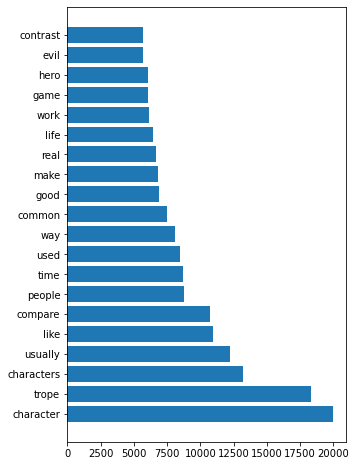

In [21]:
# let's get the n-gram frequencies
bag_of_words, ngram_freqs, ngram_labels = get_top_ngram(tropes['Description'],
                                                        ngram_range=(1,2), top_n= 20)

# let's plot them (most common ones are at the bottom)
plt.figure(figsize=(5,8))
_ = plt.barh(y=range(20), width=ngram_freqs,tick_label=ngram_labels)


### Excercise

They're not too bad. But, these are pretty much all unigrams. That is because single tokens are much more frequent than pairs of tokens. Perhaps we can show the bi-grams separately?

(Also note "characters" and "character", which shuold be joined. This issue should be taken care of using lemmatization, however scikit-learn's CountVectorizer does **not** include lemmatization by default).

Let's get just the bigrams - how would you modify the code below to achieve this?

Remember that ngram_range determines the minimum and maximum number of contiguous tokens we want to consider. For example ngram_range=(1,3) means taking all unigrams, bigrams and trigrams.

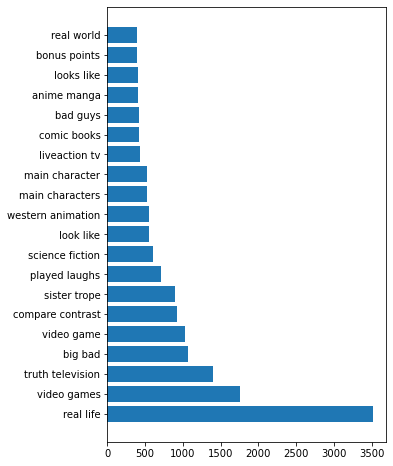

In [22]:
# let's get the n-gram frequencies (ONLY 2-grams this time)
bag_of_words, ngram_freqs, ngram_labels = get_top_ngram(tropes['Description'],
                                                        ngram_range=(1,2), top_n= 20)

# let's plot them (most common ones are at the bottom)
plt.figure(figsize=(5, 8))
_ = plt.barh(y=range(20),width=ngram_freqs,tick_label=ngram_labels)

# Measuring trope genderedness

The goal is to quantify how much each trope is gendered (in a binary way) towards "male" or "female" concepts (not an objective reality! More correctly, we'd say how much each trope contains words that are typically associated with men and women and therefore can be perceived by people as being more or less gendered in a certain - binary - way).

To do this, following the paper we will:
1. Represent a trope by its description and ALL its examples.
2. Find the number of occurrences for "female" and "male" words.
3. Compute a "local" ratio for each trope.


In [23]:
# First, we need to group all examples of tropes in films by the trope and join all of them up
film_tropes['AllExamples'] = film_tropes.groupby('TropeLower')['Example'].transform(
    lambda x: ' '.join(x))


In [24]:
# you can see in the last columns that all occurrences of the same trope have the same "AllExamples" entry
film_tropes[film_tropes.TropeLower=='cliffhanger'].head()

,Title,Trope,Example,trope_id,title_id,TropeLower,ReadableTrope,AllExamples
47879,Bolt,CliffHanger,created order make show within show appealing ...,t03882,f1742,cliffhanger,Cliff Hanger,created order make show within show appealing ...
48595,BossNigger,CliffHanger,film ends boss gets shot multiple times may dy...,t03882,f1782,cliffhanger,Cliff Hanger,created order make show within show appealing ...
58942,Carnosaur,CliffHanger,third movies ending reveals dinosaurs ship sol...,t03882,f2175,cliffhanger,Cliff Hanger,created order make show within show appealing ...
138618,HarryPotterAndTheDeathlyHallows,CliffHanger,end voldemort obtains elder wand dumbledores g...,t03882,f5327,cliffhanger,Cliff Hanger,created order make show within show appealing ...
151956,IfAManAnswers,CliffHanger,dont know called chantal telephone end know wa...,t03882,f5970,cliffhanger,Cliff Hanger,created order make show within show appealing ...


In [25]:
# let's retain only tropes and examples
# we can drop the duplicates
tropes_and_examples = film_tropes[['TropeLower','AllExamples']].drop_duplicates()
tropes_and_examples.head()


,TropeLower,AllExamples
0,msfanservice,concert segments make clear agnetha fridas loo...
1,insistentterminology,radio station manager tasks ashley delivering ...
2,deadpansnarker,band moments one crowning examples agnethas re...
3,dayinthelife,film follows abba tour clerks mallrats clerks ...
4,themetunecameo,brief snippet knowing knowing well dum dum did...


In [26]:
# now let's join up the dataframes so that each trope gets the full list of examples
# we join on TropeLower so we are not derailed by spelling mistakes
augmented_tropes = pd.merge(tropes, tropes_and_examples, left_on = 'TropeLower', right_on = 'TropeLower',
                           how= 'left')
augmented_tropes['DescAndExamples'] = augmented_tropes['Description'] + ' ' + augmented_tropes['AllExamples'].fillna('')


In [27]:
# let's see the results - there should be two extra columns
augmented_tropes.sample(3, random_state = 42)

,TropeID,Trope,Description,TropeLower,ReadableTrope,AllExamples,DescAndExamples
423,t00563,Allegory,allegory work thats designed metaphor somethin...,allegory,Allegory,eventually becomes clear chan less individual ...,allegory work thats designed metaphor somethin...
3522,t04793,CrossCulturalHandshake,shaking hands isnt culturespecific habit sure ...,crossculturalhandshake,Cross Cultural Handshake,parodied like things airplane ted stryker upon...,shaking hands isnt culturespecific habit sure ...
15067,t20462,SkeleBot9000,visual trope science fiction materials humanoi...,skelebot9000,Skele Bot9000,advanced mechas ending highly evolved robots e...,visual trope science fiction materials humanoi...


Let's load the list of words that we will use to quantify the perceived and binary genderdeness of tropes.

In [28]:
# data loading
with open('male_word_file.txt') as f:
    male_words = f.read()
male_words = male_words.split('\n')
    
print(male_words[:3])

# data loading
with open('female_word_file.txt') as f:
    female_words = f.read()
female_words = female_words.split('\n')
print(female_words[:3])


['countryman', 'fraternal', 'wizards']
['countrywoman', 'sororal', 'witches']


### Count all occurrences of male and female terms in each augmented trope.

We will use Spacy to make this easy.

[Reference: [spaCy 101](https://spacy.io/usage/spacy-101#whats-spacy)]

spaCy is a free, open-source python library for advanced NLP, designed specifically for production use. This means that it's optimized to "get things done" by making some decisions on behalf of the user, based on the latest research and on what spaCy's developers determined was the best trade-off. This generally means slightly less flexibility and a bit more efficiency.

spaCy is mostly based on "trained pipelines", similarly to what we saw with scikit-learn's pipelines. These are collections of ordered components that use previously trained statistical models to process a text dataset. For example, the tokenizer is part of a pipeline.

Trained pipelines are behind spaCy's features and capabilities.

The most important feature in the pipeline is, as mentioned, the tokenizer, which is used to split a text document into its constituent tokens. Tokens are often, but not always, equivalent to individual words and symbols. Thinking in terms of tokens allows us to consider each text as a different ordered sequence of a limited number of tokens. Indeed, the set of all unique tokens used across all documents in our dataset is called the "vocabulary".

When working with english text there are three main pipeline often used. These have been trained on the same web data, but are based on statistical models of different sizes. Generally, larger models are more accurate but slower. The pipeline names are:

1. `en_core_web_sm`: this is the pipeline with the smallest models. Start here to see if this is powerful enough.
2. `en_core_web_md`: medium models: use them if you need more powerful models.
3. `en_core_web_lg`: largest models: use them if you need the most powerful models (that is, nothing else is working).

These pipelines work with the English language, but Spacy also has pipelines for other languages!

In [29]:
nlp = spacy.load("en_core_web_sm")

#### A note on Tokenization

To count the top n-grams we have used scikit-learn tokenizer, while now we will use Spacy's.

Each tokenizer will act slightly differently. spaCy [tokenizes](https://spacy.io/usage/spacy-101#annotations-token) a text by following a rule-based algorithm, looking for contiguous portions of alpha-numeric characters. This means it ignores punctuation by default and would, for example, keep "we've" as "we've" (initially!). It also has a rule though that "we've" should be split as "we", "'" and "ve". The specific rules depends on the language we are using.

The advantage of using Spacy is that we have more flexibility in how we tokenize **and** we can also lemmatize a text. Scikit-learn doesn't offer lemmatization by default. The disadvantage is that using Spacy is slower. Both can handle stop words.

Here, we use different libraries because each of them (sklearn and Spacy) have different specialties, so it's easier to use for some things but not for others.

For some projects, though, it may be important to use the same tokenizer throughout. To do this, one would need to modify some of the building block or arguments of the functions used, but it is possible to use Spacy tokenizer together with sklearn CountVectorizer. One option, which is a bit slow to compute, is to use Spacy to tokenize and lemmatize each document, save the results and use that text representation throughout.



In [30]:
# this is going to take a few minutes, it's normal!
t0= time.time()
docs = list(nlp.pipe(augmented_tropes['DescAndExamples'], 
            ##disabling NLP capabilities that are irrelevant for the task at hand can speed things up
           disable=["tok2vec","ner","parser","textcat"])) 
print(f'Overall it took {(time.time()-t0)/60:.3f} minutes.')


Overall it took 3.970 minutes.


In [31]:
# let's explore Spacy's capabilities a bit
for i,token in enumerate(docs[1]):
    print('The original token is: ', token)
    print("It's lemmatized version is: ", token.lemma_)
    print('Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) :', token.is_stop)
    print()
    if i>9:
        break
        

The original token is:  catchphrases
It's lemmatized version is:  catchphrases
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  great
It's lemmatized version is:  great
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  simple
It's lemmatized version is:  simple
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  way
It's lemmatized version is:  way
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  help
It's lemmatized version is:  help
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  characters
It's lemmatized version is:  characters
Is it a stop word? (We removed some before, but Spacy might 

In [32]:
from spacy.matcher import PhraseMatcher # this is what we need to find specific patterns of words in a text.

# PhraseMatcher is used with these following steps:
# 1. create an instance of PhraseMatcher (one for each list of words to match)
# 2. process the list of words to match using a minimal processing pipeline 
# (this is because Spacy always works with text processed through one of its pipelines)
# 3. Add the processed list of words to the matcher.


male_matcher = PhraseMatcher(nlp.vocab)
# As per Spacy's suggestion, we only run nlp.make_doc() instead of nlp() to speed things up 
# (minimal pipeline with little more than the tokenizer)
male_patterns = [nlp.make_doc(text) for text in male_words]
male_matcher.add("TerminologyList", male_patterns)

female_matcher = PhraseMatcher(nlp.vocab)
female_patterns = [nlp.make_doc(text) for text in female_words]
female_matcher.add("TerminologyList", female_patterns)


def match_gendered_terms(matcher, trope):
    # Function to apply a matcher to a given document (trope).
    # It finds all the relevant words and only returns how many there are
    trope_doc = trope
    matches = matcher(trope_doc)
    return len(matches)

    

In [33]:

t0 = time.time()
female_tokens_nb = []
male_tokens_nb = []
for doc in docs:
    # for each document (a trope) match all "male" and "female" words and count how many we found
    female_tokens_nb.append(match_gendered_terms(female_matcher,doc))
    male_tokens_nb.append(match_gendered_terms(male_matcher,doc))
    
print(f'Overall it took {time.time()-t0:.2f} seconds')

# store everything in a dataframe
augmented_tropes['FemaleTokensNb'] = female_tokens_nb
augmented_tropes['MaleTokensNb'] = male_tokens_nb


Overall it took 0.69 seconds


### Compute a "genderedness" ratio.

From the paper:
The raw genderedness score of trope i is the ratio:

\begin{equation}
d_{trope} = \frac{f(trope)}{f(trope) + m(trope)} / \frac{f(tropes)}{f(tropes) + m(tropes)}
\end{equation}

This score is a trope’s proportion of female tokens among gendered tokens, normalized by the global ratio in the corpus. If $d_{trope}$ is high, that trope contains a larger-than-usual proportion of female words.

We finally calculate the the genderedness score $g_{trope}$ as $d_{trope}$’s normalized z-score. This results in scores from −negative (male-dominated) to positive (female-dominated) values. For our analyses, we consider tropes with genderedness scores outside of [−1, 1]
(one standard deviation) to be highly gendered (see Table 2 for examples). 

While similar to methods used in prior work (Garcia et al., 2014), our genderedness score is limited by its lexicon and susceptible to gender generalization and explicit marking (Hitti et al.,2019). We leave exploration of more nuanced methods of capturing trope genderedness (Ananya et al.,2019) to future work.


In [34]:
# Find the "female" proportion of matches across ALL tokens
total_male_matches = augmented_tropes['MaleTokensNb'].sum()
total_female_matches = augmented_tropes['FemaleTokensNb'].sum()
r_tropes = total_female_matches / (total_male_matches + total_female_matches)
print(f'The global ratio is {r_tropes:.2}')

The global ratio is 0.31


In [35]:
# Get some more statistics that will be helpful later

# number of tokens in each trope
augmented_tropes['TokensNb'] = [len(doc) for doc in docs]

# number of gendered tokens (total and split)
augmented_tropes['GenderedTokensNb']= augmented_tropes['FemaleTokensNb'] + augmented_tropes['MaleTokensNb']

augmented_tropes['MaleTokensRatio'] = augmented_tropes['MaleTokensNb']/augmented_tropes['TokensNb']
augmented_tropes['FemaleTokensRatio'] = augmented_tropes['FemaleTokensNb']/augmented_tropes['TokensNb']


In [36]:
from sklearn.preprocessing import StandardScaler

# compute the local proportion of female tokens for a trope
augmented_tropes['fm_ratio'] = augmented_tropes['FemaleTokensNb']/(
    augmented_tropes['FemaleTokensNb']+augmented_tropes['MaleTokensNb'])

# divide by the global ratio
augmented_tropes['raw_gender_score']= augmented_tropes['fm_ratio']/r_tropes

# set tropes where no gendered token at all was found to Not A Number
augmented_tropes.loc[((augmented_tropes['MaleTokensNb']==0) & (augmented_tropes['FemaleTokensNb']==0)),
                    'raw_gender_score'] == pd.NA

# standardize the scores (that is, subtract the average score across tropes and divide by the standard deviation)
scaler= StandardScaler()
augmented_tropes['gender_score']= scaler.fit_transform(augmented_tropes[['raw_gender_score']])


In [37]:
# Some tropes are more noise than signal.
# For some things, we'll only keep tropes with at least 300 tokens and with at least 1% of gendered terms
tokens_th = 300 # this is 1000 in the paper, but they also use a larger dataset
ratio_th = 0.01
filtered_tropes = (augmented_tropes['TokensNb']>tokens_th) & (
    augmented_tropes['GenderedTokensNb']/augmented_tropes['TokensNb']>ratio_th)


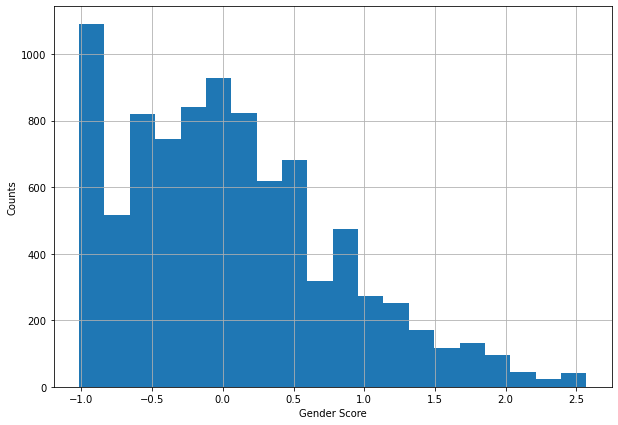

In [38]:
# histogram of the scaled ratio: what is the distribution of scores across tropes?
ax = augmented_tropes.loc[filtered_tropes, 'gender_score'].hist(bins=20, figsize = (10,7))
ax.set_xlabel('Gender Score')
_=ax.set_ylabel('Counts')


Which tropes have the most extreme gender scores?


In [39]:
# let's sort to have lowest score at the top ("Male-dominated tropes")
augmented_tropes.loc[filtered_tropes, ['ReadableTrope','gender_score','GenderedTokensNb','FemaleTokensNb','MaleTokensNb',
                                       'FemaleTokensRatio','MaleTokensRatio',
                                      'TokensNb','Description']].sort_values(by = ['gender_score','MaleTokensNb'],
                                                               ascending=[True,False]).head()



,ReadableTrope,gender_score,GenderedTokensNb,FemaleTokensNb,MaleTokensNb,FemaleTokensRatio,MaleTokensRatio,TokensNb,Description
16161,Superhero Paradox,-1.016706,100,0,100,0.0,0.017085,5853,superheroes try make world safer innocents lon...
14827,Shooting Superman,-1.016706,71,0,71,0.0,0.019404,3659,believe villain doesnt realize simply shoot he...
6654,Giant Mook,-1.016706,63,0,63,0.0,0.027913,2257,minion henchman big strong tough ordinary mook...
17075,Thematic Rogues Gallery,-1.016706,63,0,63,0.0,0.026729,2357,hero egregious tropeman amazing troperelated p...
9006,Kidnapped By An Ally,-1.016706,58,0,58,0.0,0.034856,1664,character forcibly brought meet someone plot t...


In [40]:
# let's sort again to have highest score at the top ("Female-dominated tropes")
augmented_tropes.loc[filtered_tropes, ['ReadableTrope','gender_score','GenderedTokensNb','FemaleTokensNb','MaleTokensNb',
                                       'FemaleTokensRatio','MaleTokensRatio',
                                      'TokensNb','Description']].sort_values(by = ['gender_score','FemaleTokensNb'],
                                                               ascending=False).head()



,ReadableTrope,gender_score,GenderedTokensNb,FemaleTokensNb,MaleTokensNb,FemaleTokensRatio,MaleTokensRatio,TokensNb,Description
17449,The Weird Sisters,2.571065,31,31,0,0.086835,0.0,357,supernatural women often form teams three comm...
12683,Plenty Of Blondes,2.571065,20,20,0,0.033445,0.0,598,characters fair hair seen frequently expected ...
11804,One Drink Will Kill The Baby,2.571065,17,17,0,0.034979,0.0,486,know fetal alcohol syndrome irreversible brain...
19658,Zettai Ryouiki,2.571065,16,16,0,0.027586,0.0,580,absolute territory 絶対領域 zettai ryouiki describ...
14150,Running The Blockade,2.571065,15,15,0,0.024038,0.0,624,blockade siege city country dependent trade so...


How about the "genderedeness" of two specific genres? (Action and Romance)

In [41]:
# match films to genres
# we only have two genres because IMBD data is not publicly available (it's "public", but not open source), 
# so I did some (limited!) manual matching

# check the genre distribution
film_to_genre.Genre.value_counts()


romance    29
action     15
Name: Genre, dtype: int64

In [42]:
# let's join the films we have with their genre (for some, at least)
augmented_film_tropes = pd.merge(film_tropes, 
                                 augmented_tropes[['TropeLower','gender_score','GenderedTokensNb',
                                                   'FemaleTokensNb','MaleTokensNb','TokensNb']],
                                how='left', left_on = 'TropeLower', right_on= 'TropeLower')

# we do this by matching using the lowercase film title
augmented_film_tropes['TitleLower'] = augmented_film_tropes['Title'].str.lower()
augmented_film_tropes = pd.merge(augmented_film_tropes,
                                film_to_genre,
                                how= 'left', left_on = 'TitleLower', right_on= 'TitleLower')


In [43]:
# Let's see what the average and the standard deviation of the Gender ratio is for the two different genres
# Remember that negative values mean higher than average Male Tokens
# Positive values mean higher than average Female Tokens
augmented_film_tropes.groupby('Genre')['gender_score'].agg(['mean','std'])


,mean,std
Genre,,
action,-0.069388,0.707233
romance,0.282834,0.722557


## A quick further look at the word matching

Using Spacy's PhraseMatcher, we matched **exact** occurrences of the "male" and "female" words as they appear in the tropes' descriptions and examples. 

What if there are spelling mistakes? What if we want to also look for **similar** words, without needing to re-do the original list every time.

In short, we might want to do some "fuzzy" (that is, non-exact) matching.

Two possible tools that may help with this are: a) comparing words using the Levenshtein distance and b) comparing words using word embeddings. 

While we won't see the Levensthein distance in this tutorial, briefly this is a tool that allows us to quantify how similar two words are based on the 'minimum number of single-character edits required to change one word into the other'. For example, 'trope' and 'trpe' would have a distance of 1. This can be a good tool to catch spelling mistakes, though be careful: also 'take' and 'bake' have a distance of 1! A good python implementation is the [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) package.

Let's see what we can do with embeddings.

#### Using embeddings for similarity matching

As mentioned, we can represent words (and text data in general) via embeddings. A word embedding is a representation of a word via a list of numbers, where each vector is computed in a way that attempts to preserve the semantic meaning of each word. These vectors are called dense since most of their entries will not be zero. 

This allows to store information in a more compact manner and therefore reduce the dimensionality of our data. Word embeddings are usually trained on large collections of text, since they have to learn and leverage statistical patterns in text data. A famous word embedding model is ["Word2Vec"](https://arxiv.org/abs/1301.3781) by Mikolov et al.

The good news is that spaCy comes with word embeddings that someone else has already trained! (Although the documentation for how exactly they are trained is sparse). 
That is, Spacy has a mapping from words to pre-made lists of numbers that are meant to encode the semantic meaning of those words (it's not **all** possible words, but it's typically a large enough vocabulary).

With spaCy we can obtain a vector embedding for each of the tokens in the text. spaCy even provides a vector for the whole document which is given by the average vector embedding across all tokens in the document (this strategy often works better for short texts).

We can access the word/document embeddings via the .vector attribute.

Once we have embeddings, we can compute how similar two words are based on how similar their embeddings are. The similarity of two embeddings is computed using a metric called cosine similarity. This is a number between -1 and 1, where:

- -1 suggests two words are "antonyms".
- 0 suggests two words are completely unrelated.
- 1 suggests two words are "synonyms".


##### Implementation note

Lastly, a note about Spacy.

When we call `nlp= spacy.load('en_core_web_md')` (or similar), what we are doing is importing a collection of pre-made algorithms into our python workspaces so that we can apply them to our dataset.

`'en_core_web_sm'`, `'en_core_web_md'` and `'en_core_web_lg'` are three slightly different collections of NLP algorithms, also called NLP pipelines.

'sm' (=small), 'md' (=medium) and 'lg' (=large) refer to the "size" of the algorithms: the bigger the size the more complex the algorithms are. Complexity means that they are more powerul, but also take up more memory and computational resources. The suggestion is to choose the minimal complexity needed to solve your specific problem.

There is an important note to make when using word embeddings. `'en_core_web_sm'` is too small a Spacy pipeline **and does not come with word embeddings**. If you want to use embeddings, you need to choose either `'en_core_web_md'` or `'en_core_web_lg'`. I suggest starting from `'en_core_web_md'`.


In [44]:
# let's load the proper Spacy pipeline (before we use en_core_web_md which does not have a vector per token)
nlp_md = spacy.load("en_core_web_md")

t0= time.time()
# For speed, we will only apply it to the first 20 tropes only
docs_md = list(nlp_md.pipe(augmented_tropes.sort_values(by='GenderedTokensNb',ascending=False)['DescAndExamples'].head(20), 
            ##disabling NLP capabilities that are irrelevant for the task at hand can speed things up
           disable=["ner","parser","textcat"])) 
print(f'Overall it took {(time.time()-t0)/60:.3f} minutes.')



Overall it took 0.450 minutes.


In [45]:
# let's obtain the embedding for each gendered word

# this is how many numbers are in each embedding (the dimension of the embedding)
emb_dim = len(docs_md[0][0].vector)

# "male" words
docs_male = nlp_md.pipe(male_words)
# this create a matrix (a collection of numbers stored as a table) that initially contains all 0s. 
# We create a table with nb of rows = nb of male words and nb of columns = the dimension of the embedding
male_embs = np.zeros((len(male_words), emb_dim)) 
for i,doc in enumerate(docs_male):
    male_embs[i,:] = doc.vector

# same for "female" words
docs_female = nlp_md.pipe(female_words)
female_embs = np.zeros((len(female_words), emb_dim))
for i,doc in enumerate(docs_female):
    female_embs[i,:] = doc.vector


In [46]:

# let's try it on the first trope
# first, we will store an embedding for each token.
doc = docs_md[0]
doc_matrix_embs = np.zeros((len(doc), emb_dim))
for i,token in enumerate(doc):
    doc_matrix_embs[i,:] = token.vector
    
# now compute the cosine similarity between each token and each "male" word
trope_male_similarity = cosine_similarity(doc_matrix_embs,male_embs)

# We define a threshold: two words match if their cosine similarity is more than 0.99.
similarity_threshold = .99
# For each token in a trope, it is a match if it matches at least one of the "male" words with a cosine similarity > 0.99
matched_words = []
for i in range(trope_male_similarity.shape[0]):
    if (trope_male_similarity[i,:]>similarity_threshold).any():
        if doc[i].text not in matched_words:
            print('Matched word:', doc[i].text, f'. Is it in the original list? {doc[i].text in male_words}')
            matched_words.append(doc[i].text)
# example new words matched --> strong, fireman (can be a bit cyclical), but also widow.


Matched word: actors . Is it in the original list? True
Matched word: country . Is it in the original list? False
Matched word: fireman . Is it in the original list? False
Matched word: wizard . Is it in the original list? True
Matched word: cameraman . Is it in the original list? True
Matched word: horsemen . Is it in the original list? True
Matched word: man . Is it in the original list? True
Matched word: boy . Is it in the original list? True
Matched word: brother . Is it in the original list? True
Matched word: king . Is it in the original list? True
Matched word: kings . Is it in the original list? True
Matched word: camera . Is it in the original list? False
Matched word: widow . Is it in the original list? False
Matched word: son . Is it in the original list? True
Matched word: strong . Is it in the original list? False
Matched word: prince . Is it in the original list? True


### Exercise

Try and modify the code below so that we explore the word embedding matches for a **different trope**.

For example, instead of using the first trope, what happens if we check the fourth one?

Then/Or, try to decrease the similarity threshold from .99 to .95. Do we get more useful or misleading words?


In [47]:
# let's try it on the fourth trope this time
# first, we will store an embedding for each token.
doc = docs_md[0]
doc_matrix_embs = np.zeros((len(doc), emb_dim))
for i,token in enumerate(doc):
    doc_matrix_embs[i,:] = token.vector
    
# now compute the cosine similarity between each token and each "male" word
trope_male_similarity = cosine_similarity(doc_matrix_embs,male_embs)

# We define a threshold: two words match if their cosine similarity is more than 0.99.
similarity_threshold = .99
# For each token in a trope, it is a match if it matches at least one of the "male" words with a cosine similarity > 0.99
matched_words = []
for i in range(trope_male_similarity.shape[0]):
    if (trope_male_similarity[i,:]>similarity_threshold).any():
        if doc[i].text not in matched_words:
            print('Matched word:', doc[i].text, f'. Is it in the original list? {doc[i].text in male_words}')
            matched_words.append(doc[i].text)



Matched word: actors . Is it in the original list? True
Matched word: country . Is it in the original list? False
Matched word: fireman . Is it in the original list? False
Matched word: wizard . Is it in the original list? True
Matched word: cameraman . Is it in the original list? True
Matched word: horsemen . Is it in the original list? True
Matched word: man . Is it in the original list? True
Matched word: boy . Is it in the original list? True
Matched word: brother . Is it in the original list? True
Matched word: king . Is it in the original list? True
Matched word: kings . Is it in the original list? True
Matched word: camera . Is it in the original list? False
Matched word: widow . Is it in the original list? False
Matched word: son . Is it in the original list? True
Matched word: strong . Is it in the original list? False
Matched word: prince . Is it in the original list? True


# Topic Modelling using Latent Dirichlet Allocation

Extracted and adapted from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py (© Copyright 2007 - 2024, scikit-learn developers (BSD License)). Code is provided "as is" (full disclaimer notice at the end).

Topic modelling is a technique to decompose an entire collection of documents into the topics it is likely to be made of.

Specifically, the idea is that the words in each document are not random, but appear because of the topics that each document is about. We know the words in the document (they are the observed variables), then we want to find N topics (and their associated words) that explain as much of all the documents as possible. Here, topic is intended with a more specific meaning that in it's common usage. Rather than being a concept, or a field, we need to interpret a topic as a collection of words and the strength of association between each topic and those words.

A commonly used technique to find the topics is called Latent Dirichlet Allocation (LDA). LDA (not to be confused with Linear Discriminant Analysis) finds the topics from a collection of documents, each represented using a count-based Bag of Word model.

Training a LDA model means finding the N topics (with N decided by us) that best explain a given collection of documents.

Once we find the topics, we can also find the most important words for each topic (typically used to understand what the topic is about) and the most important topic(s) for each document.

In [53]:


n_samples = 6000
n_features = 1000
n_topics = 75
n_top_words = 20

data_filtered = augmented_tropes[filtered_tropes].sort_values(by='gender_score').copy()
df = pd.concat((data_filtered[:(n_samples//2)],data_filtered[-(n_samples//2):]))


# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(df['DescAndExamples'])

print(
    "\n" * 2,
    f"Fitting LDA models with tf features, n_samples={n_samples} and n_features={n_features}..."
)
# create the (untrained) model.
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    random_state=0,
)
# train LDA on our tropes.
t0 = time.time()
lda.fit(tf)
print(f"done in {(time.time()-t0):.3f} seconds.")



Extracting tf features for LDA...


 Fitting LDA models with tf features, n_samples=6000 and n_features=1000...
done in 58.435 seconds.


In [54]:
# let's get the 20 top words for each topic
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names_out()

top_words_cols = [f'top_word_{i}' for i in range(20)]
top_weights_cols = [f'weight_word_{i}' for i in range(20)]

for topic_idx, topic in enumerate(lda.components_):
    if topic_idx==0:
        topic_df = pd.DataFrame(columns = top_words_cols + top_weights_cols) # we'll store all the information here
    
    # get the indices corresponding to the top words
    top_features_ind = topic.argsort()[-n_top_words:]
    # link those indices to the top words
    top_features = tf_feature_names[top_features_ind]
    # get the weight of how important each word is for the topic
    weights = topic[top_features_ind]
    #topic_df_[top_words_cols]= top_features
    #topic_df_[top_weights_cols]= weights
    # with each new topic we create a new row for the dataframe which we will then append to the main one
    topic_df_ = pd.DataFrame(index= top_words_cols + top_weights_cols, 
                             data = list(top_features) + list(weights))
    #print(topic_df_.T.columns)
    topic_df = pd.concat((topic_df, topic_df_.T))

topic_df = topic_df.reset_index(drop=True)

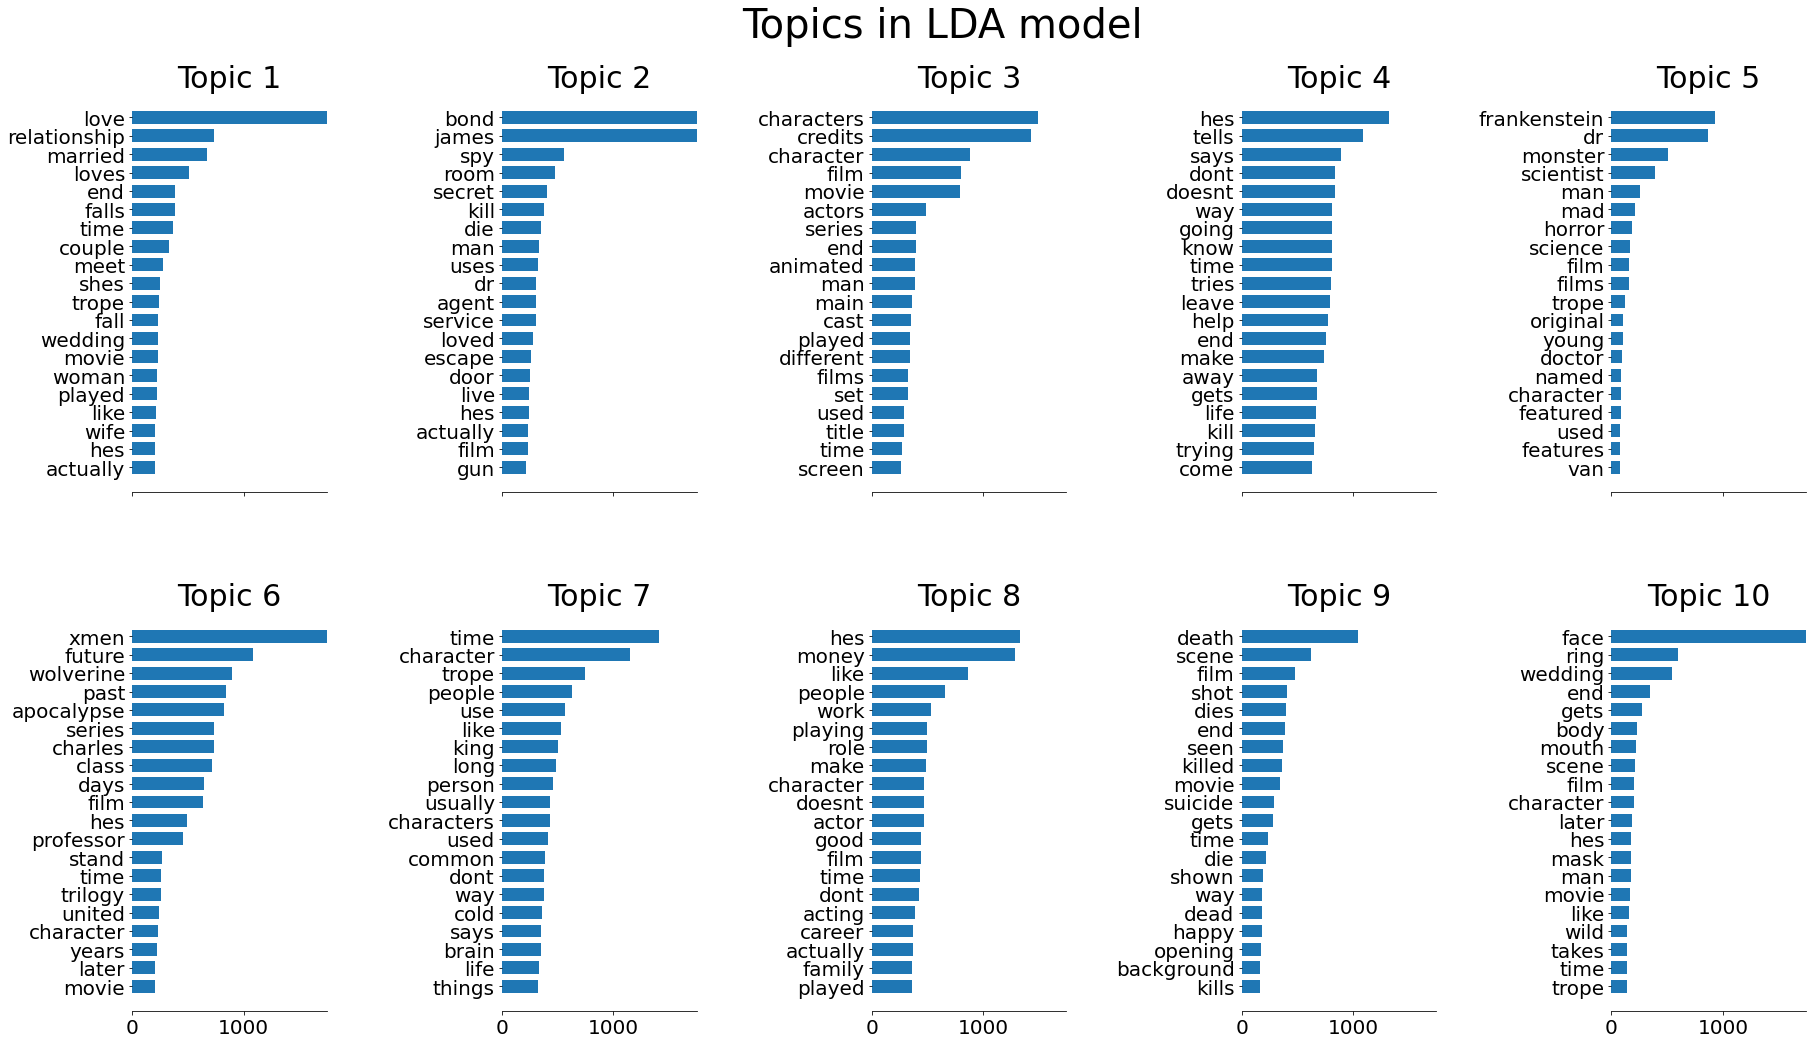

In [55]:

    
def plot_top_words(model, feature_names, n_top_words, title, topics_ids = range(10)):
    # only plots the first 10 topics
    assert(len(topics_ids)<=10) #won't work if there are too many topics to plot
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for i, topic_idx in enumerate(topics_ids):
        topic = model.components_[topic_idx]
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[i]
        ax.barh(top_features, weights, 0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        ax.set_xlim([0,max(weights)+0.1])
        fig.suptitle(title, fontsize=40)
        
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [56]:
# now, let's use the trained LDA model to project each trope into the topics 
# based on how much each topic relates to each trope
trope_to_topics= lda.transform(tf)

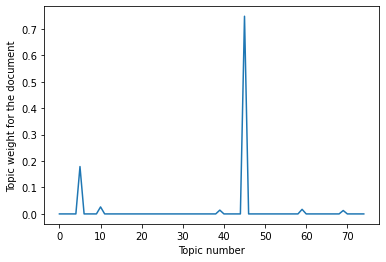

In [57]:
# Let's show an example: let's plot the distribution of the first document across all topics
# The more highly the document depends on a topic, the higher the weight of that document for that topic
# (very high weights will appear as "spikes" in the plot below)
plt.plot(trope_to_topics[0])
plt.xlabel('Topic number')
_= plt.ylabel('Topic weight for the document')


In [59]:
# so, for each trope we can get the topic that is most highly associated with it (the highest peak in the plot above)
# using python's function "argmax" (= the index at which the maximum number in a list appears)
df['most_probable_topic'] = trope_to_topics.argmax(axis=1)


In [61]:
# now, for each topic we can compute how many of the tropes associated with it lean "male" (gender score <0)
# or "female" (gender score > 0 )
# Finally, we can compute the ratio of the two numbers above
topics_to_gender = []
topic_df['topic_genderedness'] = 1
topic_df['female_leaning'] = pd.NA
topic_df['male_leaning'] = pd.NA

for topic_nb, g in df.groupby('most_probable_topic'):
    nb_male_leaning = (g['gender_score']<0).sum()
    nb_female_leaning = (g['gender_score']>0).sum()
    if (nb_female_leaning==0) & (nb_male_leaning==0):
        r = 1
    else:
        #we add +1 only to avoid a division by 0 
        # (and it's kind of like we are considering 0 a "rounding error", it's not very rigorous though).
        r = (nb_female_leaning+1)/(nb_male_leaning+1) 
    topics_to_gender.append(r) 
    topic_df.loc[topic_nb, 'topic_genderedness'] = r
    topic_df.loc[topic_nb, 'female_leaning'] = nb_female_leaning
    topic_df.loc[topic_nb, 'male_leaning'] = nb_male_leaning



In [62]:
# now, we say that a topic is "female leaning" if a higher proportion of its tropes are "female leaning"
print(f'Number of "female leaning" *topics*: {(topic_df["topic_genderedness"]>1).sum()}')
print(f'Number of "male leaning" *topics*: {(topic_df["topic_genderedness"]<1).sum()}')


Number of "female leaning" *topics*: 32
Number of "male leaning" *topics*: 41


In [63]:
topic_df.sort_values(by= ['topic_genderedness','male_leaning'], ascending= [True,False])

,top_word_0,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9,...,weight_word_13,weight_word_14,weight_word_15,weight_word_16,weight_word_17,weight_word_18,weight_word_19,topic_genderedness,female_leaning,male_leaning
54,guardians,dark,character,real,heroes,final,leader,movie,revealed,like,...,576.017228,578.634538,632.551932,768.924269,854.264656,1683.284332,1817.111563,0.090909,1,21
32,alien,island,japanese,features,original,films,fights,attack,movie,final,...,1213.334065,1272.911853,1287.738139,1673.097266,1872.155889,2133.766548,5647.961184,0.125000,3,31
33,training,bad,hard,soldier,battle,glass,men,theyre,air,force,...,344.002446,406.696342,495.907506,616.184782,668.997248,867.340844,939.946694,0.195122,7,40
53,trope,half,dr,new,end,kill,death,destroyed,heroes,entire,...,129.112289,131.384355,131.449666,165.076062,174.706618,183.767388,207.692263,0.222222,3,17
28,original,episode,film,like,ii,years,space,later,officer,movie,...,462.026008,731.880781,826.851701,979.843572,1422.381893,2448.225981,2695.576393,0.239130,10,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,return,dracula,alien,saw,final,curse,iii,children,ghost,living,...,442.591068,450.492602,733.681342,765.681713,826.926662,1147.06901,1328.414077,4.666667,13,2
66,wears,color,book,girl,played,trope,black,head,dark,shes,...,202.354125,231.387636,231.895666,250.260021,283.586546,329.712304,2668.249033,6.500000,51,7
37,end,away,kids,little,later,daughter,family,dead,son,film,...,940.764988,947.867947,1095.957156,1145.86704,1371.015389,1421.914619,1826.965988,11.750000,93,7
38,friend,family,gets,film,female,girls,friends,hes,life,like,...,989.083289,1119.502611,1198.428026,1491.994263,1799.561857,2161.288754,2326.907054,27.375000,437,15


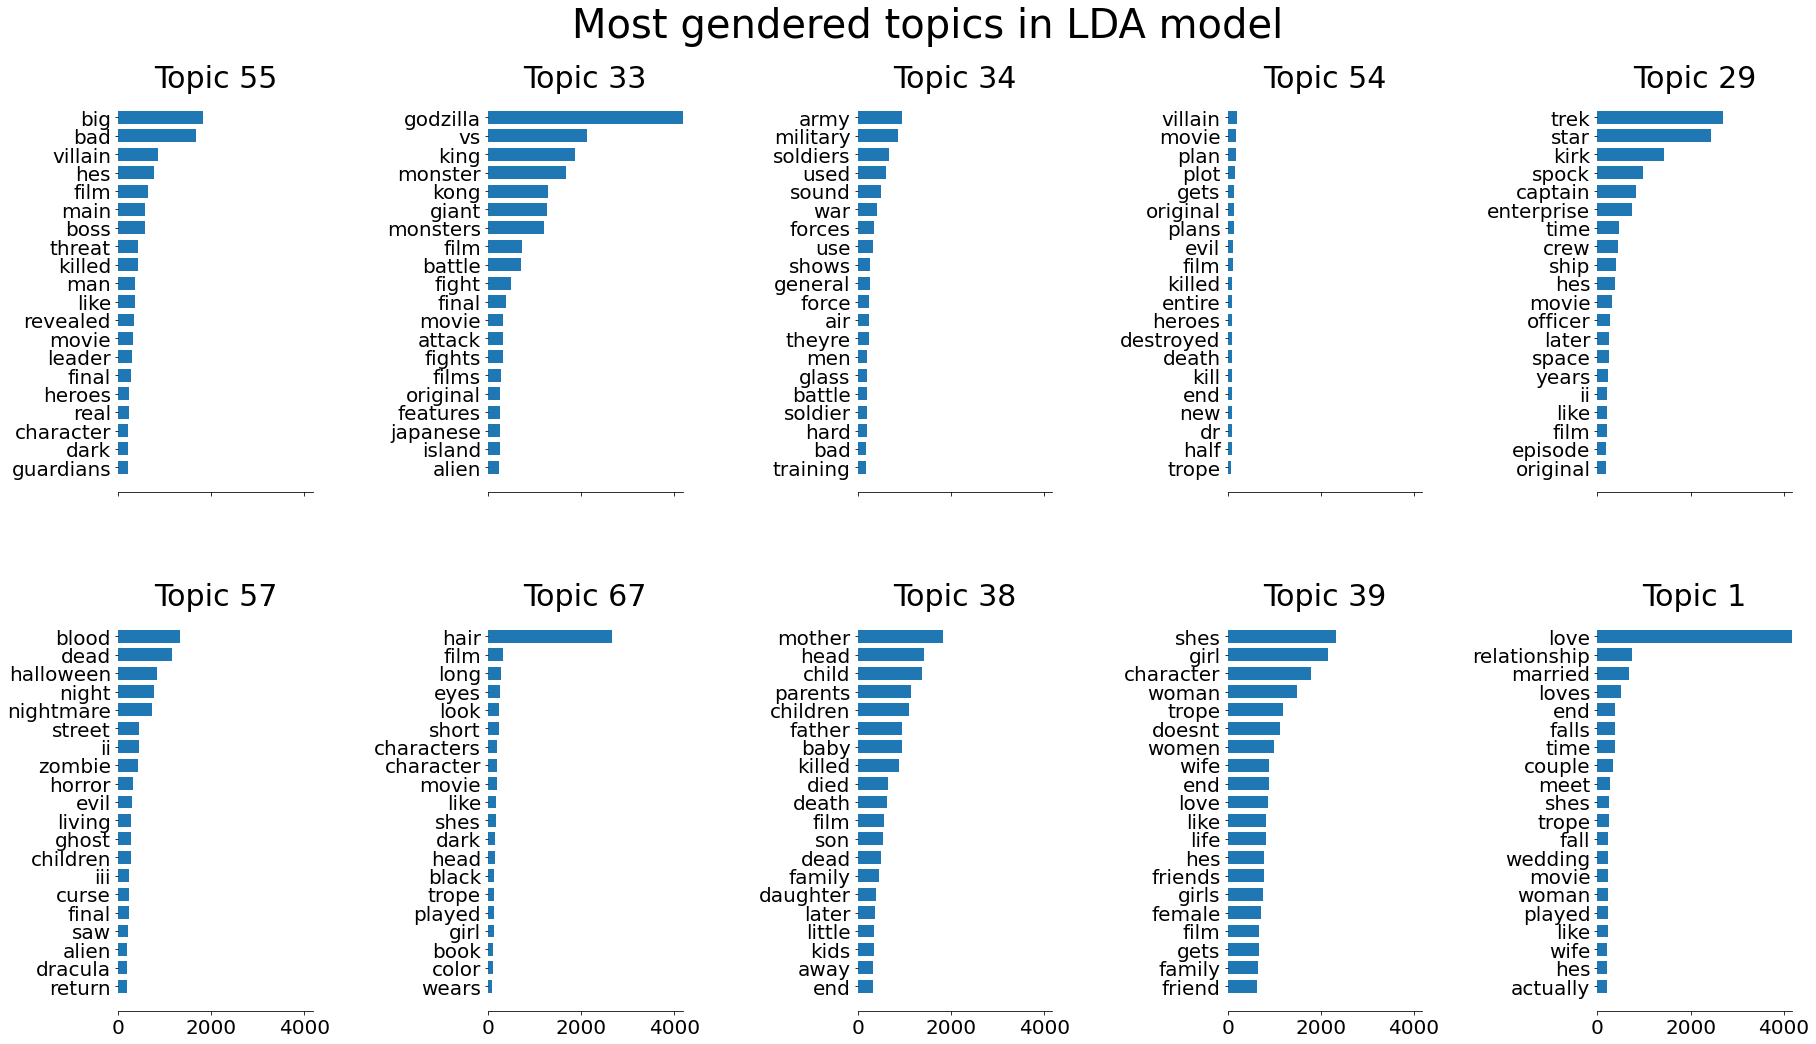

In [64]:
# let's take the top 5 "male" and "female" topics
topics_to_plot = topic_df.sort_values(by= ['topic_genderedness','male_leaning'], 
                                      ascending= [True,False]).index[[0,1,2,3,4,-5,-4,-3,-2,-1]]

plot_top_words(lda, tf_feature_names, n_top_words, "Most gendered topics in LDA model",
              topics_ids= topics_to_plot)

Disclaimer notice for the code adapted from scikit-learn's documentation:

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.